<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/Explore_NormAndLightingBatchTransformsTPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# colab
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [4]:
#colab
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5115  100  5115    0     0  33431      0 --:--:-- --:--:-- --:--:-- 33431
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
     |████████████████████████████████| 61kB 2.6MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     


In [5]:
# colab
!pip install fastai2 --upgrade > /dev/null
!pip freeze | grep fastai2

fastai2==0.0.18


In [6]:
#colab
!pip install git+https://github.com/butchland/fastai_xla_extensions > /dev/null
!pip freeze | grep fastai_xla_extensions

  Running command git clone -q https://github.com/butchland/fastai_xla_extensions /tmp/pip-req-build-q8q_m3v5


In [7]:
#colab
!pip install git+https://github.com/butchland/my_timesaver_utils > /dev/null
!pip freeze | grep my_timesaver_utils

  Running command git clone -q https://github.com/butchland/my_timesaver_utils /tmp/pip-req-build-8r88gmdj


### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai_xla_extensions.core import *

In [3]:
from fastai2.vision.all import *

In [4]:
from my_timesaver_utils.profiling import *

### Setup data

In [5]:
path = untar_data(URLs.PETS)/'images'

### Loop through batch and walk through batch transforms

In [6]:
# from IPython.core.debugger import set_trace

In [7]:
# TRACE = True

In [8]:
orig_randtransform_call = RandTransform.__call__
def __call__(self, b, split_idx=None, **kwargs):
    is_lighting_tfm = isinstance(self, LightingTfm) 
    if is_lighting_tfm:
#         print(f'applying AffineCoordTfm call {self}')
#         if TRACE: set_trace()
        start_record('lighting_tfm_call')
    results = orig_randtransform_call(self, b, split_idx, **kwargs)
    if is_lighting_tfm:
        end_record('lighting_tfm_call')
    return results

In [9]:
setattr(RandTransform,'__call__', __call__)

In [10]:
# orig_normalize_encodes = Normalize.encodes

# def encodes(self, x:TensorImage):
#     start_record('normalize_encodes')
#     results = orig_normalize_encodes(self,x)
#     end_record('normalize_encodes')
#     return results

In [11]:
# setattr(Normalize,'encodes', encodes)

In [12]:
# def mycompose_tfms(x, tfms, is_enc=True, reverse=False, **kwargs):
#     "Apply all `func_nm` attribute of `tfms` on `x`, maybe in `reverse` order"
#     if reverse: tfms = reversed(tfms)
#     for f in tfms:
#         if not is_enc: f = f.decode
#         if isinstance(f,AffineCoordTfm): 
#             print(f'applying {type(f)} {f} to {type(x)}')
#             if TRACE:
#                 set_trace()
#         x = f(x, **kwargs)
#     return x


In [13]:
# @patch_to(Pipeline)
# def __call__(self, o): return mycompose_tfms(o, tfms=self.fs, split_idx=self.split_idx)

In [14]:
# TRACE = False

In [15]:
batch_tfms = [*aug_transforms(max_zoom=1.0, max_warp=0., max_rotate=0., max_lighting=0.2,do_flip=False)]
batch_tfms

[LightingTfm: (TensorImage,object) -> encodes ]

In [16]:
batch_tfms[0].fs

(#2) [<fastai2.vision.augment._BrightnessLogit object at 0x7fb19185c2b0>,<fastai2.vision.augment._ContrastLogit object at 0x7fb19185c320>]

In [17]:
pat = r'(.+)_\d+.jpg$'

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [18]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(seed=42),
    get_y=using_attr(RegexLabeller(pat),'name'),
    item_tfms=Resize(224),
    batch_tfms=batch_tfms
   
)

In [19]:
print_prof_data()

In [20]:
datablock.summary(path)

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_36.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/saint_bernard_36.jpg
    applying partial gives
      saint_bernard
    applying Categorize gives
      TensorCategory(30)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(30))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=500x333, TensorCategory(30))
    applying Res

In [21]:
print_prof_data()

Function lighting_tfm_call called 2 times.
Execution time max: 0.130, average: 0.073


### Setup DataLoaders

In [22]:
bs=256

In [23]:
dls = datablock.dataloaders(path,bs=bs)

In [24]:
dls.device

device(type='xla', index=1)

In [25]:
dls.train

In [26]:
train_dl = dls.train

In [27]:
train_dl.device

device(type='xla', index=1)

In [ ]:
# def fetch_one_batch():
#     if TRACE: set_trace()
#     dl_iter = train_dl.__iter__()
#     b = dl_iter.__next__()

In [ ]:
# TRACE = False

In [28]:
clear_prof_data();print_prof_data()

In [ ]:
# fetch_one_batch()

In [ ]:
# print_prof_data()

In [29]:
clear_prof_data(); print_prof_data()

In [30]:
def fetch_all_batches():
    for b in train_dl:
        pass

In [31]:
fetch_all_batches()

In [32]:
print_prof_data()

Function lighting_tfm_call called 23 times.
Execution time max: 0.041, average: 0.018


In [33]:
times = get_prof_data('lighting_tfm_call')

In [34]:
# times2 = get_prof_data('normalize_encodes')

In [35]:
import matplotlib.pyplot as plt

In [36]:
times

[0.039724111557006836,
 0.013995647430419922,
 0.013826847076416016,
 0.013138294219970703,
 0.013603925704956055,
 0.017247438430786133,
 0.019514799118041992,
 0.01510000228881836,
 0.017765522003173828,
 0.015016794204711914,
 0.0405731201171875,
 0.014321565628051758,
 0.014142751693725586,
 0.015550374984741211,
 0.021960973739624023,
 0.015275716781616211,
 0.015179157257080078,
 0.016428470611572266,
 0.016570568084716797,
 0.015159845352172852,
 0.014460325241088867,
 0.014637947082519531,
 0.014634132385253906]

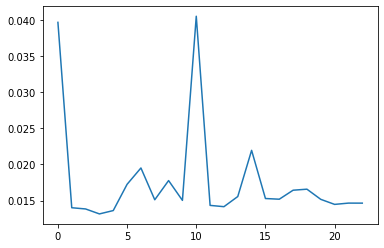

In [37]:
plt.plot(times);

In [ ]:
# times2

In [ ]:
# plt.plot(times2);